## ASSIGNMENT-2
Roll Numbers:

Names:

### Instructions
 * Fill in the roll numbers and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.

## G2O Motion Model 

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive nodes k and k+1.

## PART 2

### 1. ICP Alignment with LieTorch (5 marks)
Resources: https://github.com/princeton-vl/lietorch/tree/master

Perform ICP Alignment of 2 PointClouds using LieTorch. Similar to what was expected in Part 1, you will be given a random Transformation matrix from the getTransform function. You are expected to transform the Toothless Point Cloud by this transformation, add noise to both sets of points (original and transformed) and estimate both, the Transformation matrix and the original point cloud.

Visualize your results using open3d

In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from lietorch import SE3, LieGroupParameter
import torch
import torch.optim as optim

def getTransform():
    euler_angles = torch.rand(3) * (2 * torch.pi)
    translation = torch.rand(3) * 500.0
    transformation_param = torch.cat((translation, euler_angles))
    return SE3.exp(transformation_param)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/tmp/ipykernel_1814533/2025291877.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.vec = torch.nn.Parameter(torch.tensor(torch.cat((t, q)), dtype=torch.float32))


48593.96484375
754921.9375
847341.8125
11047.73828125
792898.1875
460072.9375
109597.40625
753923.4375
276539.9375
120411.1796875
389232.71875
254455.34375
575588.25
335881.90625
695956.3125
115455.5625
289730.71875
413334.71875
10162.2197265625
366902.3125
301764.15625
409435.40625
223512.3125
407633.15625
41489.04296875
358447.3125
121006.421875
81849.6640625
279783.25
102457.1171875
235422.234375
60202.328125
291549.90625
55236.30859375
150038.53125
209303.859375
222906.59375
412937.6875
71519.0546875
463388.6875
134191.6875
281982.875
53388.2265625
100348.421875
203378.875
247273.046875
431545.1875
42242.1328125
414389.4375
179314.40625
313752.0
63474.265625
101552.390625
211915.265625
50014.47265625
219378.6875
132592.90625
350705.03125
35586.0234375
196101.609375
225785.25
184499.03125
404292.5625
121518.7578125
486520.625
93408.75
238547.09375
100609.765625
147707.8125
24139.375
59222.50390625
101989.6171875
149435.109375
236487.59375
120568.4765625
404814.5625
125353.8671875
35

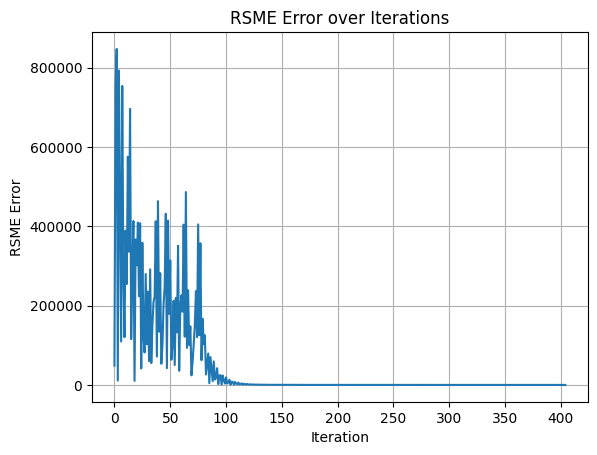

In [10]:
def transform_point_cloud(point_cloud, SE3_transform, downsample=1.0):
    if downsample < 1.0:
        indices = torch.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]
    
    transformation_matrix = SE3_transform.matrix()
    rotated_points = torch.matmul(point_cloud, transformation_matrix[:3, :3].T)
    transformed_points = rotated_points + transformation_matrix[:3, 3]
    
    return transformed_points

def compute_loss(pcl0, pcl1_transformed):
    residuals = pcl1_transformed - pcl0
    loss = torch.norm(residuals) ** 2
    return loss

transform0 = getTransform()
transform1 = getTransform()

downsample = 0.01

pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_tensor = torch.tensor(np.array(pcl.points), dtype=torch.float32)

pcl0 = transform_point_cloud(pcl_tensor + torch.randn_like(pcl_tensor) * 1, transform0, downsample)
pcl0_tensor = pcl0.requires_grad_(True)
pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0.detach().numpy()))
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])

pcl1 = transform_point_cloud(pcl_tensor + torch.randn_like(pcl_tensor) * 1, transform1, downsample)
pcl1_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl1.detach().numpy()))
pcl1_geom.paint_uniform_color([0.0, 0.0, 1.0])
pcl1_tensor = pcl1.requires_grad_(True)

frame0 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
frame_torch = torch.tensor(np.array(frame0.vertices), dtype=torch.float32)
frame1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcl0_geom)
vis.add_geometry(pcl1_geom)
vis.add_geometry(frame0)
vis.add_geometry(frame1)
vis.poll_events()
vis.update_renderer()

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        q = torch.randn(4)
        q = q / q.norm()
        t = torch.randn(3)
        self.vec = torch.nn.Parameter(torch.tensor(torch.cat((t, q)), dtype=torch.float32))

    def forward(self, input):
        t = self.vec[:3]
        q = self.vec[3:]
        q = q / q.norm()
        normalized_vec = torch.cat((t, q))
        se3_transform = SE3.InitFromVec(self.vec)
        return transform_point_cloud(input,se3_transform)

model = Model()
optimizer = optim.SGD(model.parameters(), 4e-0, momentum=0.9,weight_decay=0)

errors = []

for i in range(1000):
    optimizer.zero_grad()
    y_hat = model(pcl1_tensor)
    loss = torch.nn.functional.mse_loss(y_hat, pcl0_tensor)
    loss.backward()
    optimizer.step()

    opti_transform = SE3.InitFromVec(model.vec)

    pcl1_geom.points = o3d.utility.Vector3dVector(transform_point_cloud(pcl1_tensor,opti_transform).detach().numpy())
    pcl0_geom.points = o3d.utility.Vector3dVector(pcl0_tensor.detach().numpy())
    frame1.vertices = o3d.utility.Vector3dVector(transform_point_cloud(frame_torch,opti_transform).detach().numpy())
    vis.update_geometry(pcl0_geom)
    vis.update_geometry(pcl1_geom)
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    error = loss.item()
    print(error)
    errors.append(error)
    
    if error < 3e0:
        pcl0_geom.paint_uniform_color([0.0, 1.0, 0.0])
        pcl1_geom.paint_uniform_color([0.0, 1.0, 0.0])
        vis.update_geometry(pcl0_geom)
        vis.update_geometry(pcl1_geom)
        print(f"Converged in {i} iterations with {error:.4f} error.")
        break

if error > 3e0:
    print("Failed to converge")

vis.run()
vis.destroy_window()

plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RSME Error')
plt.title('RSME Error over Iterations')
plt.grid()
plt.show()

### 2. ICP-SLAM with LieTorch (10 marks)

For this part, you will be given a set of `N` transformation matrices (Each relative to position 0). Add a random amount of noise to each of the `N` sets of points. Estimate the Transforms as well as the original point cloud using LieTorch.

Visualize your results using open3d

In [3]:
def getTransforms():
    # Output shape - (n, 4, 4)
    pass

In [4]:
'''
YOUR CODE HERE
'''

'\nYOUR CODE HERE\n'